In [70]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [71]:
# Load the datasets
train_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Train.csv')
test_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv')
validation_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Validation.csv')

In [72]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [74]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df


for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31) 
    df = add_cyclical_features(df, 'Month', 12)


In [75]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW']  # Add other relevant features as needed

# Applying the function to your datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)


In [76]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Applying transformation to all datasets
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)

y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']


In [78]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse


In [53]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid to search over
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
# }

# # Instantiate the Random Forest regressor
# random_forest = RandomForestRegressor(random_state=42)

# # Instantiate the Grid Search with 5-fold cross-validation
# grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# # Fit the Grid Search to the training data
# grid_search.fit(X_train_poly, y_train)

# # Extract the best model from the grid search
# best_model = grid_search.best_estimator_

# # Print the best parameters found by GridSearchCV
# print("Best parameters found by GridSearchCV:")
# print(grid_search.best_params_)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Since 'max_depth': 20 was found to be the best, you might want to search around it
# 'min_samples_leaf': 2 and 'min_samples_split': 10 are already quite regularized,
# but we can search around them as well
# 'n_estimators': 200 was best, but you might want to see if slightly more or less improve the result

# Define the parameter grid to search over with a narrowed range
param_grid = {
    'n_estimators': [180, 200, 220],  
    'max_depth': [15, 20, 25],  
    'min_samples_split': [8, 10, 12],  
    'min_samples_leaf': [1, 2, 3] 
}

# Instantiate the Random Forest regressor with a random state for reproducibility
random_forest = RandomForestRegressor(random_state=42)

# Instantiate the Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search to the training data
grid_search.fit(X_train_poly, y_train)

# Extract the best model from the grid search
best_model = grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 3.4min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 3.4min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 3.5min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 3.5min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 3.5min
Best parameters found by GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [54]:
# Save the model to a file
from joblib import dump
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_random_forest_model_V3_updated.joblib'
dump(best_model, model_filename)

['/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_random_forest_model_V3_updated.joblib']

In [80]:
from joblib import load
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_random_forest_model_V3_updated.joblib'
loaded_best_model_random_forest = load(model_filename)
y_validation_pred = loaded_best_model_random_forest.predict(X_validation_poly)  # Use X_validation_poly
validation_metrics = calculate_metrics(y_validation, y_validation_pred)
print(f"Validation Metrics: MAE={validation_metrics[0]}, MAPE={validation_metrics[1]}, sMAPE={validation_metrics[2]}, RMSE={validation_metrics[3]}")

Validation Metrics: MAE=8.432622962184118, MAPE=12.372159995317334, sMAPE=13.202407344899566, RMSE=19.592383963394976


In [81]:
from joblib import load
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_random_forest_model_V3_updated.joblib'
loaded_best_model_random_forest = load(model_filename)
y_test_pred = loaded_best_model_random_forest.predict(X_test_poly)
test_metrics = calculate_metrics(y_test, y_test_pred)
print(f"Test Metrics: MAE={test_metrics[0]}, MAPE={test_metrics[1]}, sMAPE={test_metrics[2]}, RMSE={test_metrics[3]}")

Test Metrics: MAE=5.687652870683486, MAPE=6.960938401997574, sMAPE=8.412252801096372, RMSE=12.717079284648383


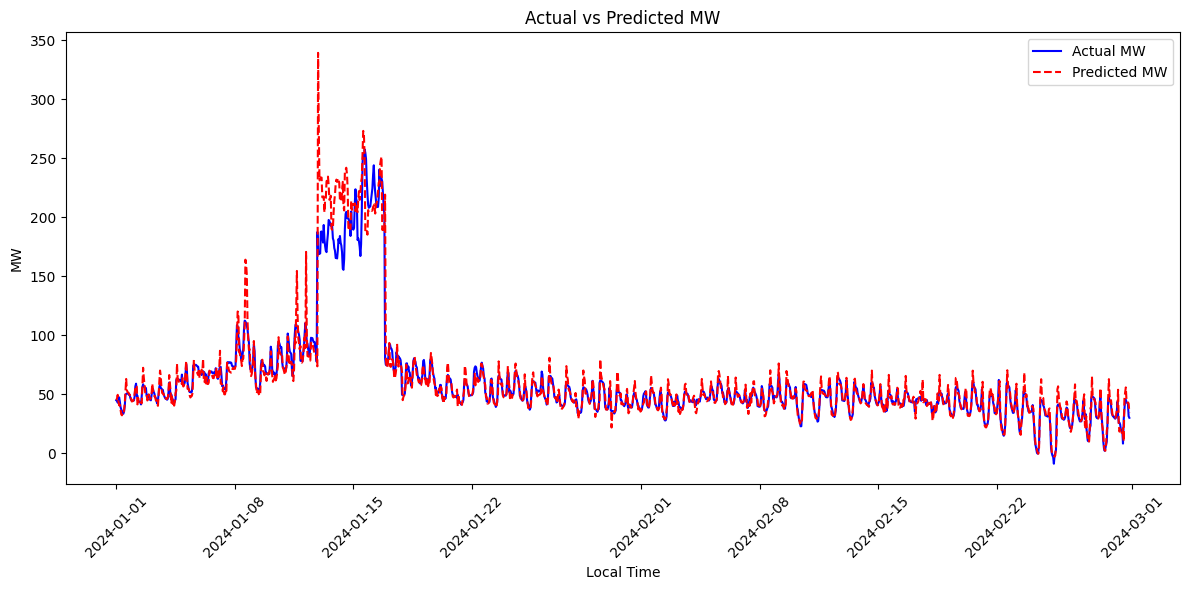

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading the 'local_time' column from the test dataset again
test_df_for_plotting = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

# Ensuring the length of test_local_time matches y_test_pred and y_test
if len(test_local_time) > len(y_test_pred):
    test_local_time = test_local_time[:len(y_test)]

plt.figure(figsize=(12, 6))
plt.plot(test_local_time, y_test[:len(test_local_time)], label='Actual MW', color='blue') 
plt.plot(test_local_time, y_test_pred, label='Predicted MW', color='red', linestyle='--')
plt.title('Actual vs Predicted MW')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

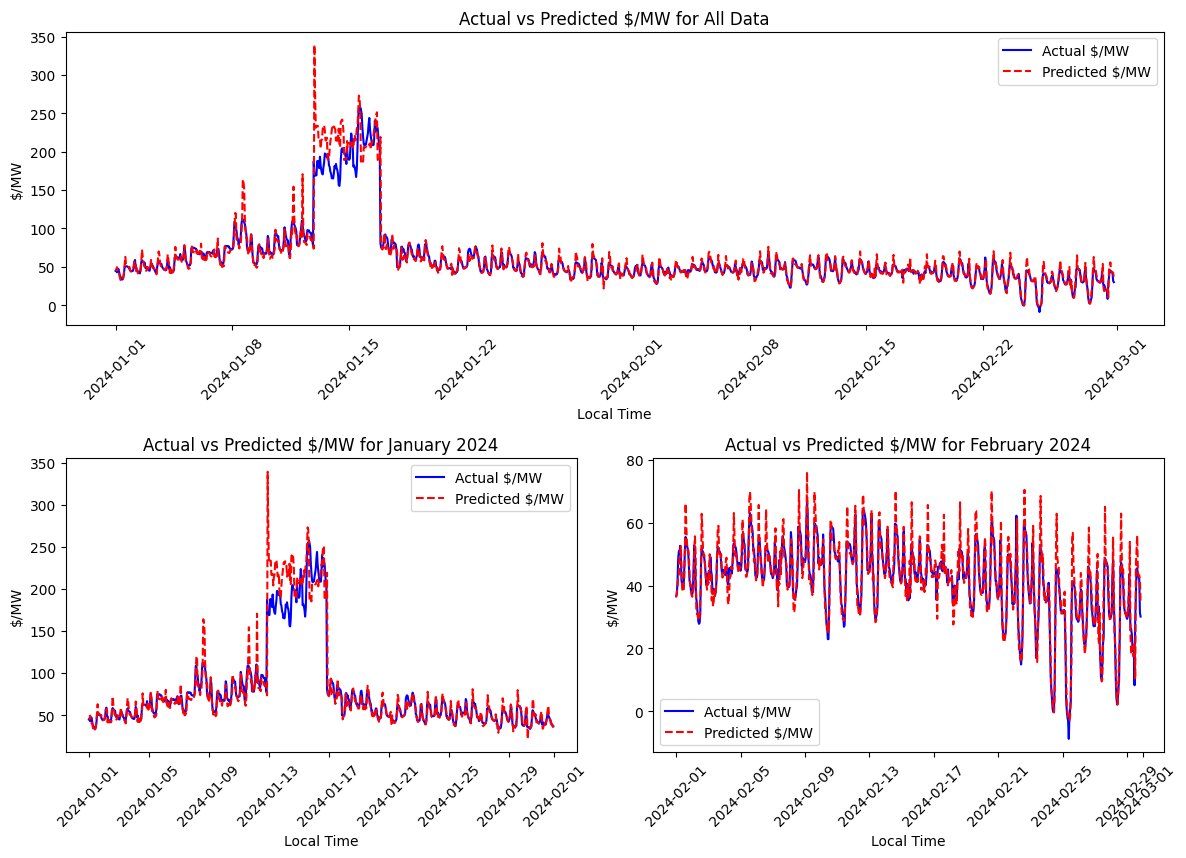

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_test_pred and y_test are already defined and correspond to predictions and actual values

# Loading the 'local_time' column from the test dataset again for plotting
test_df_for_plotting = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

# Making sure the lengths match
if len(test_local_time) > len(y_test_pred):
    test_local_time = test_local_time[:len(y_test_pred)]

# Setting up the figure and main top plot
fig = plt.figure(figsize=(12, 12))

# Main top plot
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax1.plot(test_local_time, y_test[:len(test_local_time)], label='Actual $/MW', color='blue')
ax1.plot(test_local_time, y_test_pred, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('Actual vs Predicted $/MW for All Data')
ax1.set_xlabel('Local Time')
ax1.set_ylabel('$/MW')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Filtering data for January and February
january_filter = test_local_time.dt.month == 1
february_filter = test_local_time.dt.month == 2

# Bottom left plot - January
ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=1)
ax2.plot(test_local_time[january_filter], y_test[january_filter], label='Actual $/MW', color='blue')
ax2.plot(test_local_time[january_filter], y_test_pred[january_filter], label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('Actual vs Predicted $/MW for January 2024')
ax2.set_xlabel('Local Time')
ax2.set_ylabel('$/MW')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# Bottom right plot - February
ax3 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
ax3.plot(test_local_time[february_filter], y_test[february_filter], label='Actual $/MW', color='blue')
ax3.plot(test_local_time[february_filter], y_test_pred[february_filter], label='Predicted $/MW', color='red', linestyle='--')
ax3.set_title('Actual vs Predicted $/MW for February 2024')
ax3.set_xlabel('Local Time')
ax3.set_ylabel('$/MW')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


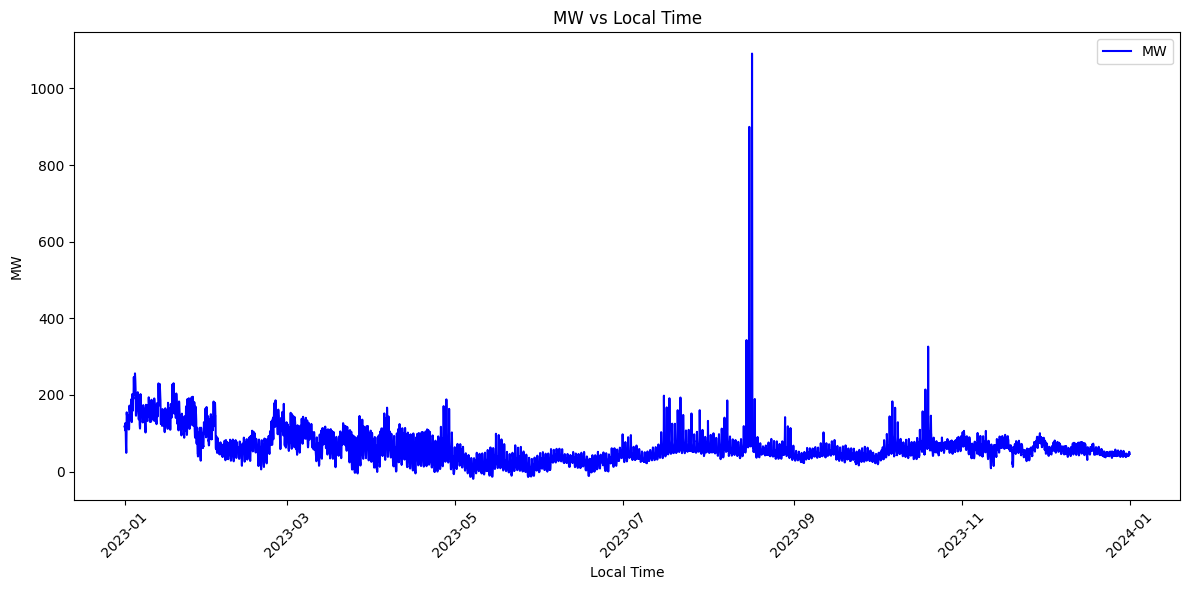

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
train_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Validation.csv')

# Convert 'local_time' to datetime if it's not already in that format
train_df['local_time'] = pd.to_datetime(train_df['local_time'])

# Plot MW against local_time
plt.figure(figsize=(12, 6))
plt.plot(train_df['local_time'], train_df['MW'], label='MW', color='blue')
plt.title('MW vs Local Time')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()


In [85]:
# Assuming best_model is your trained best model from GridSearchCV
# and calculate_metrics is the function you've already defined

# Generate predictions for each dataset
y_train_pred = best_model.predict(X_train_poly)
y_validation_pred = best_model.predict(X_validation_poly)
y_test_pred = best_model.predict(X_test_poly)

# Calculate metrics for the training dataset
train_metrics = calculate_metrics(y_train, y_train_pred)
print('Training Metrics:')
print(f"MAE: {train_metrics[0]}")
print(f"MAPE: {train_metrics[1]}")
print(f"sMAPE: {train_metrics[2]}")
print(f"RMSE: {train_metrics[3]}\n")

# Calculate metrics for the validation dataset
validation_metrics = calculate_metrics(y_validation, y_validation_pred)
print('Validation Metrics:')
print(f"MAE: {validation_metrics[0]}")
print(f"MAPE: {validation_metrics[1]}")
print(f"sMAPE: {validation_metrics[2]}")
print(f"RMSE: {validation_metrics[3]}\n")

# Calculate metrics for the test dataset
test_metrics = calculate_metrics(y_test, y_test_pred)
print('Test Metrics:')
print(f"MAE: {test_metrics[0]}")
print(f"MAPE: {test_metrics[1]}")
print(f"sMAPE: {test_metrics[2]}")
print(f"RMSE: {test_metrics[3]}\n")


Training Metrics:
MAE: 2.5187178501484446
MAPE: 3.641656025715265
sMAPE: 3.7264369056652695
RMSE: 8.816601242154245

Validation Metrics:
MAE: 8.432622962184118
MAPE: 12.372159995317334
sMAPE: 13.202407344899566
RMSE: 19.592383963394976

Test Metrics:
MAE: 5.687652870683486
MAPE: 6.960938401997574
sMAPE: 8.412252801096372
RMSE: 12.717079284648383



In [86]:
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)


Best parameters found by GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [87]:
import pandas as pd

# Assuming train_df, validation_df, and test_df are already defined
# Convert Year, Month, Day (and Hour if necessary) to a datetime object
for df in [train_df, validation_df, test_df]:
    if 'Hour' in df.columns:
        df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
    else:
        df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')

# Now you can check the date ranges as previously attempted
print("Training date range:", train_df['date'].min(), "to", train_df['date'].max())
print("Validation date range:", validation_df['date'].min(), "to", validation_df['date'].max())
print("Test date range:", test_df['date'].min(), "to", test_df['date'].max())

# Ensure there is no overlap
assert train_df['date'].max() < validation_df['date'].min(), "Overlap between train and validation sets"
assert validation_df['date'].max() < test_df['date'].min(), "Overlap between validation and test sets"


KeyError: "None of [Index(['Year', 'Month', 'Day'], dtype='object')] are in the [columns]"